In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter


# 1. 读取数据
data = pd.read_csv('/total/data_2.csv')
y = data.iloc[:, -1]
x = data.iloc[:, :-1]
# 2. 选取示例样本
def get_example_samples(x, y, n_samples=1):
    """获取正常和异常的示例样本"""
    normal_idx = y[y == 0].index[:n_samples]
    anomaly_idx = y[y == 1].index[:n_samples]
    return x.loc[normal_idx], x.loc[anomaly_idx]

normal_samples, anomaly_samples = get_example_samples(x, y)

# 配置路径和样式
output_dir = "/hy-tmp/0625/"
os.makedirs(output_dir, exist_ok=True)

开始生成可视化图表...


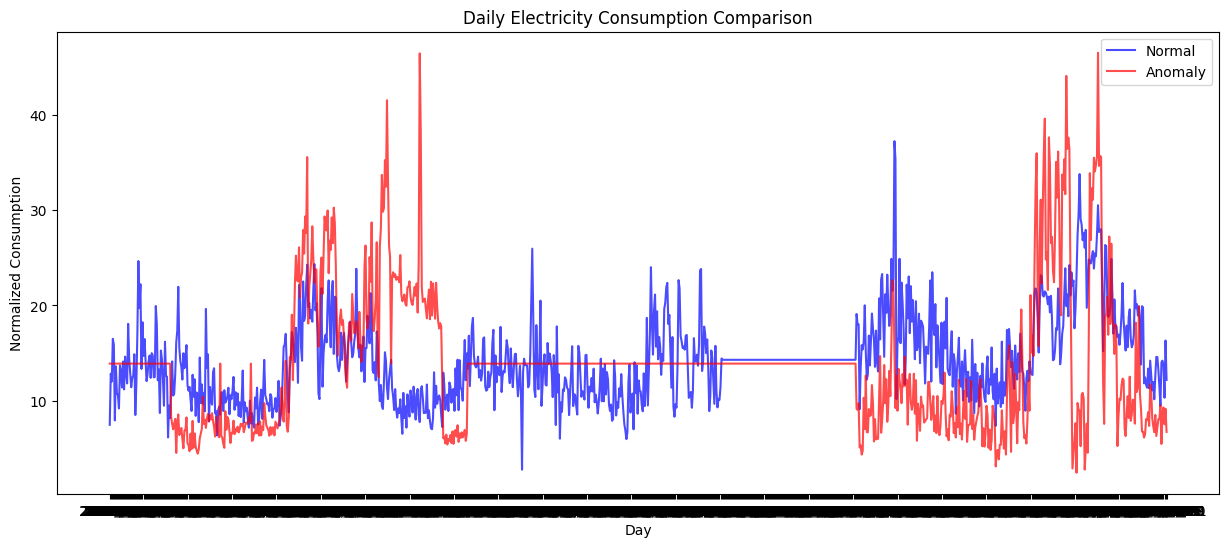

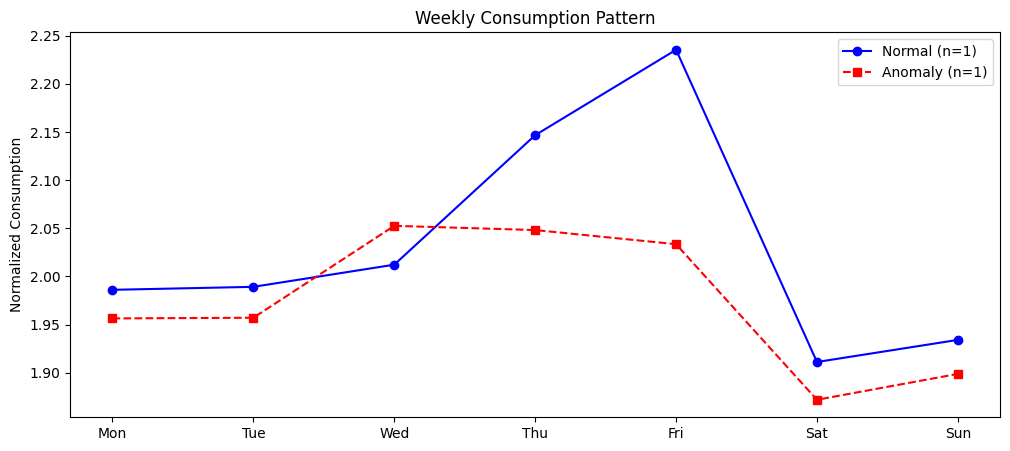

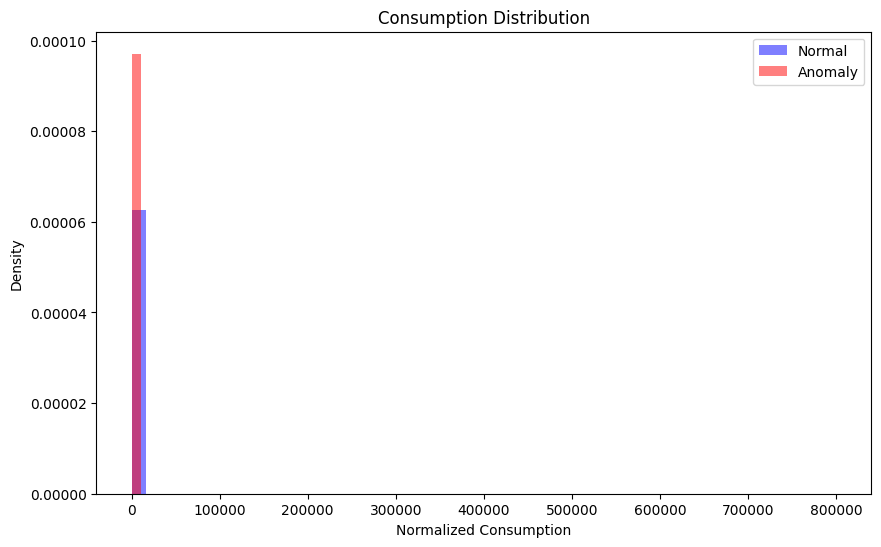

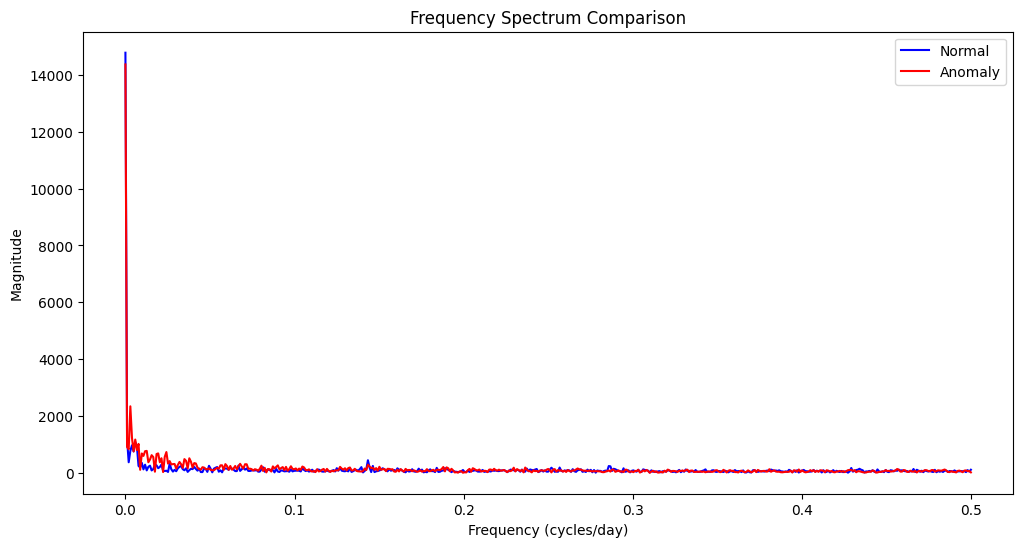

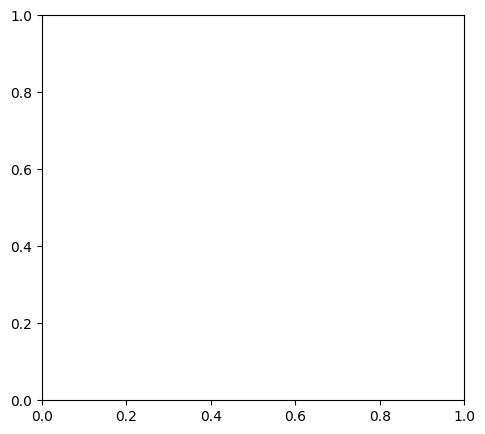

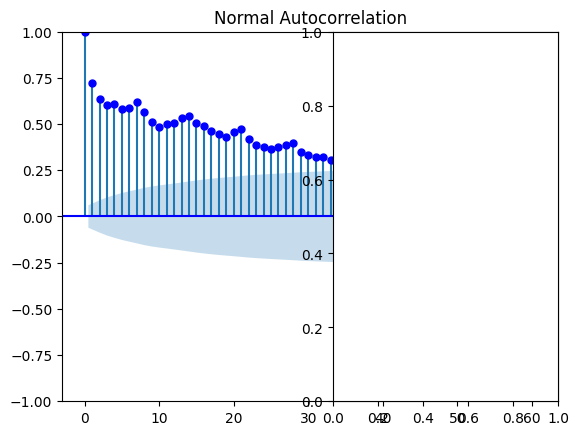

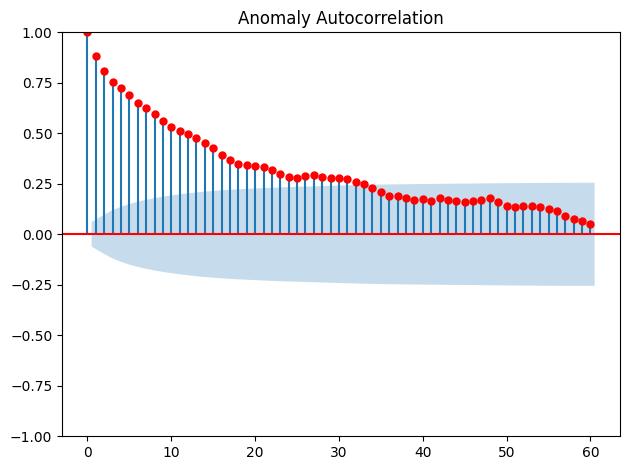

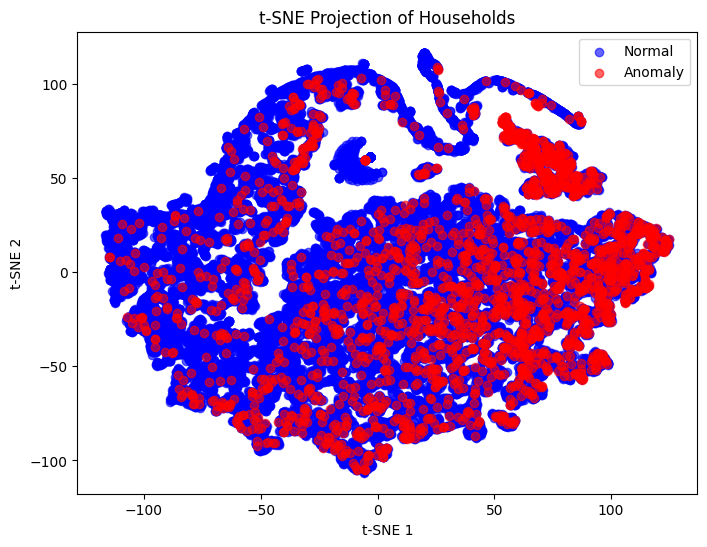

所有图表已保存至: /hy-tmp/0625/


In [8]:
# 3. 核心可视化函数
def plot_time_series(normal, anomaly, save_path=None):
    """绘制时间序列对比图"""
    plt.figure(figsize=(15, 6))
    plt.plot(normal.iloc[0], 'b-', alpha=0.7, label='Normal')
    plt.plot(anomaly.iloc[0], 'r-', alpha=0.7, label='Anomaly')
    plt.title('Daily Electricity Consumption Comparison')
    plt.xlabel('Day')
    plt.ylabel('Normalized Consumption')
    plt.legend()
    if save_path:
        plt.savefig(os.path.join(save_path, 'time_series.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_weekly_pattern(normal, anomaly, save_path=None):
    """绘制周模式图"""
    plt.figure(figsize=(12, 5))
    
    # 计算每周平均（假设数据按天连续记录）
    for i, (data, label) in enumerate(zip([normal, anomaly], ['Normal', 'Anomaly'])):
        padded_length = (len(data) + 6) // 7 * 7
        padded_data = np.pad(data.values, (0, padded_length - len(data)), mode='constant', constant_values=0)
        weekly_data = padded_data.reshape(-1, 7).mean(axis=0)
        plt.plot(weekly_data, 'o-' if i==0 else 's--', 
                 color='blue' if i==0 else 'red', 
                 label=f'{label} (n={len(data)})')
    
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.title('Weekly Consumption Pattern')
    plt.ylabel('Normalized Consumption')
    plt.legend()
    if save_path:
        plt.savefig(os.path.join(save_path, 'weekly_pattern.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_distribution(x, y, save_path=None):
    """绘制分布对比图"""
    plt.figure(figsize=(10, 6))
    plt.hist(x[y == 0].values.flatten(), bins=50, alpha=0.5, 
             color='blue', label='Normal', density=True)
    plt.hist(x[y == 1].values.flatten(), bins=50, alpha=0.5, 
             color='red', label='Anomaly', density=True)
    plt.title('Consumption Distribution')
    plt.xlabel('Normalized Consumption')
    plt.ylabel('Density')
    plt.legend()
    if save_path:
        plt.savefig(os.path.join(save_path, 'distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()

# 4. 进阶分析可视化
def plot_frequency_spectrum(normal, anomaly, save_path=None):
    """绘制频域分析图"""
    plt.figure(figsize=(12, 6))
    
    for i, (data, label) in enumerate(zip([normal, anomaly], ['Normal', 'Anomaly'])):
        fft_vals = np.abs(fft(data.iloc[0].values))[:len(data.iloc[0])//2]
        freqs = np.linspace(0, 0.5, len(fft_vals))
        plt.plot(freqs, fft_vals, 'b-' if i==0 else 'r-', label=label)
    
    plt.title('Frequency Spectrum Comparison')
    plt.xlabel('Frequency (cycles/day)')
    plt.ylabel('Magnitude')
    plt.legend()
    if save_path:
        plt.savefig(os.path.join(save_path, 'frequency_spectrum.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_autocorrelation(normal, anomaly, save_path=None):
    """绘制自相关图"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(121)
    plot_acf(normal.iloc[0], lags=60, title='Normal Autocorrelation', color='blue')
    plt.subplot(122)
    plot_acf(anomaly.iloc[0], lags=60, title='Anomaly Autocorrelation', color='red')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, 'autocorrelation.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_tsne(x, y, save_path=None):
    """绘制t-SNE降维图"""
    # 提取统计特征
    features = []
    for _, row in x.iterrows():
        features.append([
            row.mean(), row.std(), row.skew(), row.kurtosis(),
            row.max(), row.min(), row.median()
        ])

    # 转换为 NumPy 数组
    features = np.array(features)
    
    # t-SNE可视化
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings = tsne.fit_transform(features)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[y == 0, 0], embeddings[y == 0, 1], 
                c='blue', label='Normal', alpha=0.6)
    plt.scatter(embeddings[y == 1, 0], embeddings[y == 1, 1], 
                c='red', label='Anomaly', alpha=0.6)
    plt.title('t-SNE Projection of Households')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    if save_path:
        plt.savefig(os.path.join(save_path, 'tsne_projection.png'), dpi=300, bbox_inches='tight')
    plt.show()
# 5. 执行所有可视化
print("开始生成可视化图表...")
plot_time_series(normal_samples, anomaly_samples, output_dir)
plot_weekly_pattern(normal_samples, anomaly_samples, output_dir)
plot_distribution(x, y, output_dir)
plot_frequency_spectrum(normal_samples, anomaly_samples, output_dir)
plot_autocorrelation(normal_samples, anomaly_samples, output_dir)
plot_tsne(x, y, output_dir)
print(f"所有图表已保存至: {output_dir}")